## Narcissus* Backdoor attack on DP-SGD training 
- CIFAR 10 dataset
- Clean label attack

`*` Yi Zeng, Minzhou Pan, Hoang Anh Just, Lingjuan Lyu, Meikang Qiu, and Ruoxi Jia. 2023. Narcissus: A Practical Clean-Label Backdoor Attack with Limited Information. In Proceedings of the 2023 ACM SIGSAC Conference on Computer and Communications Security (CCS '23). Association for Computing Machinery, New York, NY, USA, 771–785. https://doi.org/10.1145/3576915.3616617

## Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import Optimizer
import torch.backends.cudnn as cudnn
import tqdm

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader,Subset
import torchvision.models as models
import torch.nn.functional as F
from models import *

import os
import copy
import random
import matplotlib.pyplot as plt
import numpy as np
# import cv2 as cv
# from util import *

random_seed = 0
np.random.seed(random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)


import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader, Subset

from opacus.utils.uniform_sampler import UniformWithReplacementSampler

In [2]:
#set device
torch.cuda.set_device(5)
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = 'cuda'

In [3]:
#util file for Narcissu Attack.

import logging
import os

import numpy as np
import torch
from torch.utils.data import Dataset
# import cv2 as cv
import torch.nn as nn
from collections import OrderedDict

if torch.cuda.is_available():
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


def accuracy(output, target, topk=(1,)):
    maxk = max(topk)

    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(1/batch_size))
    return res

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.max = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        self.max = max(self.max, val)


def torch_normalization(data):
    new_data = data.clone()
    if data.dim() == 4:
        _range1 = torch.max(data[0,0,:,:]) - torch.min(data[0,0,:,:])
        _range2 = torch.max(data[0,1,:,:]) - torch.min(data[0,1,:,:])
        _range3 = torch.max(data[0,2,:,:]) - torch.min(data[0,2,:,:])
        if _range1 > 0:
            new_data[0,0,:,:] = (data[0,0,:,:] - torch.min(data[0,0,:,:])) / _range1
        if _range2 > 0:
            new_data[0,1,:,:] = (data[0,1,:,:] - torch.min(data[0,1,:,:])) / _range2
        if _range3 > 0:
            new_data[0,2,:,:] = (data[0,2,:,:] - torch.min(data[0,2,:,:])) / _range3
    return new_data

def torch_normalization_inv(data,epsilon):
    new_data = data.clone()
    if data.dim() == 4:
        _range1 = torch.max(data[0,0,:,:]) - torch.min(data[0,0,:,:])
        _range2 = torch.max(data[0,1,:,:]) - torch.min(data[0,1,:,:])
        _range3 = torch.max(data[0,2,:,:]) - torch.min(data[0,2,:,:])
        if _range1 > 0:
            new_data[0,0,:,:] = (data[0,0,:,:] - torch.min(data[0,0,:,:])) / _range1
            new_data[0,0,:,:] = new_data[0,0,:,:]*(epsilon*2)/255
            new_data[0,0,:,:] = new_data[0,0,:,:] - epsilon/255
        if _range2 > 0:
            new_data[0,1,:,:] = (data[0,1,:,:] - torch.min(data[0,1,:,:])) / _range2
            new_data[0,1,:,:] = new_data[0,1,:,:]*(epsilon*2)/255
            new_data[0,1,:,:] = new_data[0,1,:,:] - epsilon/255
        if _range3 > 0:
            new_data[0,2,:,:] = (data[0,2,:,:] - torch.min(data[0,2,:,:])) / _range3
            new_data[0,2,:,:] = new_data[0,2,:,:]*(epsilon*2)/255
            new_data[0,2,:,:] = new_data[0,2,:,:] - epsilon/255
    return new_data

def norm_weight(weights):
    norm = torch.sum(weights)
    if norm != 0:
        normed_weights = weights / norm
    else:
        normed_weights = weights
    return normed_weights

def project_onto_l1_ball(x, eps):
    """
    Compute Euclidean projection onto the L1 ball for a batch.
      min ||x - u||_2 s.t. ||u||_1 <= eps
    Inspired by the corresponding numpy version by Adrien Gaidon.
    Parameters
    ----------
    x: (batch_size, *) torch array
      batch of arbitrary-size tensors to project, possibly on GPU
    eps: float
      radius of l-1 ball to project onto
    Returns
    -------
    u: (batch_size, *) torch array
      batch of projected tensors, reshaped to match the original
    Notes
    -----
    The complexity of this algorithm is in O(dlogd) as it involves sorting x.
    References
    ----------
    [1] Efficient Projections onto the l1-Ball for Learning in High Dimensions
        John Duchi, Shai Shalev-Shwartz, Yoram Singer, and Tushar Chandra.
        International Conference on Machine Learning (ICML 2008)
    """
    original_shape = x.shape
    x = x.view(x.shape[0], -1)
    mask = (torch.norm(x, p=1, dim=1) < eps).float().unsqueeze(1)
    mu, _ = torch.sort(torch.abs(x), dim=1, descending=True)
    cumsum = torch.cumsum(mu, dim=1)
    arange = torch.arange(1, x.shape[1] + 1, device=x.device)
    rho, _ = torch.max((mu * arange > (cumsum - eps)) * arange, dim=1)
    theta = (cumsum[torch.arange(x.shape[0]), rho.cpu() - 1] - eps) / rho
    proj = (torch.abs(x) - theta.unsqueeze(1)).clamp(min=0)
    x = mask * x + (1 - mask) * proj * torch.sign(x)
    return x.view(original_shape)

def proj_lp(v, xi, p):
    # Project on the lp ball centered at 0 and of radius xi
    # SUPPORTS only p = 2 and p = Inf for now
    if p == 2:
        v = v * min(1, xi/torch.linalg.norm(v.flatten(1)))
        # v = v / np.linalg.norm(v.flatten(1)) * xi
    elif p == 3:
        v = torch.sign(v) * torch.minimum(abs(v), torch.tensor(xi))
    else:
         raise ValueError('Values of p different from 2 and Inf are currently not supported...')
    return v

def get_dataset_index(target_path,target_label):

    all_content=os.listdir(target_path)

    lab_count = 0
    pass_file = 0
    target_len = 0
    for content in all_content:
        files_name = os.listdir(target_path+content)
        if lab_count == target_label:
            target_len += len(files_name)
            target_list = list(range(pass_file,pass_file+target_len))
        pass_file += len(files_name)
        lab_count += 1
    non_target_list = list(set(list(range(0,pass_file))) - set(target_list))
    return target_list,non_target_list

class my_subset(Dataset):
    r"""
    Subset of a dataset at specified indices.

    Arguments:
        dataset (Dataset): The whole Dataset
        indices (sequence): Indices in the whole set selected for subset
        labels(sequence) : targets as required for the indices. will be the same length as indices
    """
    def __init__(self, dataset, indices,labels):
        self.dataset = dataset
        self.indices = indices
        labels_hold = torch.ones(len(dataset)).type(torch.long) *300 #( some number not present in the #labels just to make sure
        labels_hold[self.indices] = labels 
        self.labels = labels_hold
    def __getitem__(self, idx):
        image = self.dataset[self.indices[idx]][0]
        label = self.labels[self.indices[idx]]
        return (image, label)

    def __len__(self):
        return len(self.indices)
        

class data_prefetcher():
    def __init__(self, loader):
        self.loader = iter(loader)
        self.stream = torch.cuda.Stream()
        self.mean = torch.tensor([0.485 * 255, 0.456 * 255, 0.406 * 255]).cuda().view(1,3,1,1)
        self.std = torch.tensor([0.229 * 255, 0.224 * 255, 0.225 * 255]).cuda().view(1,3,1,1)
        self.preload()

    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loader)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(non_blocking=True)
            self.next_target = self.next_target.cuda(non_blocking=True)
            self.next_input = self.next_input.float()
            self.next_input = self.next_input.sub_(self.mean).div_(self.std)
            
    def next(self):
        torch.cuda.current_stream().wait_stream(self.stream)
        input = self.next_input
        target = self.next_target
        self.preload()
        return input, target
    
def apply_noise_patch(noise,images,offset_x=0,offset_y=0,mode='change',padding=20,position='fixed'):
    '''
    noise: torch.Tensor(1, 3, pat_size, pat_size)
    images: torch.Tensor(N, 3, 512, 512)
    outputs: torch.Tensor(N, 3, 512, 512)
    '''
    length = images.shape[2] - noise.shape[2]
    if position == 'fixed':
        wl = offset_x
        ht = offset_y
    else:
        wl = np.random.randint(padding,length-padding)
        ht = np.random.randint(padding,length-padding)
    if images.dim() == 3:
        noise_now = noise.clone()[0,:,:,:]
        wr = length-wl
        hb = length-ht
        m = nn.ZeroPad2d((wl, wr, ht, hb))
        if(mode == 'change'):
            images[:,ht:ht+noise.shape[2],wl:wl+noise.shape[3]] = 0
            images += m(noise_now)
        else:
            images += noise_now
    else:
        for i in range(images.shape[0]):
            noise_now = noise.clone()
            wr = length-wl
            hb = length-ht
            m = nn.ZeroPad2d((wl, wr, ht, hb))
            if(mode == 'change'):
                images[i:i+1,:,ht:ht+noise.shape[2],wl:wl+noise.shape[3]] = 0
                images[i:i+1] += m(noise_now)
            else:
                images[i:i+1] += noise_now
    return images

class poison_label(Dataset):
    def __init__(self, dataset,indices,target):
        self.dataset = dataset
        self.indices = indices
        self.target = target

    def __getitem__(self, idx):
        image = self.dataset[self.indices[idx]][0]
        return (image, self.target)

    def __len__(self):
        return len(self.dataset)

class poison_image(Dataset):
    def __init__(self, dataset,indices,noise,transform):
        self.dataset = dataset
        self.indices = indices
        self.noise = noise
        self.transform = transform

    def __getitem__(self, idx):
        image = self.dataset[idx][0]
        if idx in self.indices:
            image = torch.clamp(apply_noise_patch(self.noise,image,mode='add'),-1,1)
        label = self.dataset[idx][1]
        if self.transform is not None:
            image = self.transform(image)
        return (image, label)

    def __len__(self):
        return len(self.dataset)
    
class poison_image_label(Dataset):
    def __init__(self, dataset,indices,noise,target,transform):
        self.dataset = dataset
        self.indices = indices
        self.noise = noise
        self.target = target
        self.transform = transform

    def __getitem__(self, idx):
        image = self.dataset[self.indices[idx]][0]
        image = torch.clamp(apply_noise_patch(self.noise,image,mode='add'),-1,1)
        if self.transform is not None:
            image = self.transform(image)
        return (image, self.target)

    def __len__(self):
        return len(self.indices)
    
def destructive_append(l,i):
    l=l[1:]
    l.append(i)
    return l

class get_labels(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, idx):
        return self.dataset[idx][1]

    def __len__(self):
        return len(self.dataset)
    
def load_pth(input_model,load_file_path):
    loaded_dict = torch.load(load_file_path)
    new_state_dict = OrderedDict()
    for k, v in loaded_dict.items():
        name = k[7:]
        new_state_dict[name] = v 

    input_model.load_state_dict(new_state_dict)
    input_model = input_model.cuda()
    return input_model

class concoct_dataset(torch.utils.data.Dataset):
    def __init__(self, target_dataset,outter_dataset):
        self.idataset = target_dataset
        self.odataset = outter_dataset

    def __getitem__(self, idx):
        if idx < len(self.odataset):
            img = self.odataset[idx][0]
            labels = self.odataset[idx][1]
        else:
            img = self.idataset[idx-len(self.odataset)][0]
            #labels = torch.tensor(len(self.odataset.classes),dtype=torch.long)
            labels = len(self.odataset.classes)
        #label = self.dataset[idx][1]
        return (img,labels)

    def __len__(self):
        return len(self.idataset)+len(self.odataset)

In [4]:
dataset_path ='/home/himanshugj/Documents/Project- Gradient Shaping/'

#The target class label
lab = 2

#Noise size, default is full image size
noise_size = 32

#Radius of the L-inf ball
l_inf_r = 16/255

#Model for generating surrogate model and trigger
surrogate_model = ResNet18_201().cuda()
generating_model = ResNet18_201().cuda()

#Surrogate model training epochs
surrogate_epochs = 200

#Learning rate for poison-warm-up
generating_lr_warmup = 0.1
warmup_round = 5

#Learning rate for trigger generating
generating_lr_tri = 0.01      
gen_round = 1000

#Training batch size
train_batch_size = 350

#The model for adding the noise
patch_mode = 'add'

In [5]:
#The argumention use for surrogate model training stage
transform_surrogate_train = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomCrop(32, padding=4),  
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

#The argumention use for all training set
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

#The argumention use for all testing set
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


     

In [6]:
#use a OOD dataset for generating the trigger (public data) for more transferrability
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip


--2022-12-06 21:22:10--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip.2’

tiny-imagenet-200.z 100%[===================>] 236.61M  6.16MB/s    in 52s     

2022-12-06 21:23:02 (4.57 MB/s) - ‘tiny-imagenet-200.zip.2’ saved [248100043/248100043]



In [7]:
total_size = 50000
print('==> Preparing data..')
from torchvision.datasets import CIFAR10
root = '../data/'

trainset = CIFAR10(root, train=True, transform=transforms.Compose([transforms.ToTensor()]), download=True)
# x_train, y_train = trainset.data, trainset.targets
# x_train = x_train.astype('float32')/255
# y_train = np.asarray(y_train)


testset = CIFAR10(root, train=False, transform=transforms.Compose([transforms.ToTensor()]), download=True)
# x_test, y_test = testset.data, testset.targets
# x_test = x_test.astype('float32')/255
# y_test = np.asarray(y_test)
outter_trainset = torchvision.datasets.ImageFolder(root=dataset_path + 'tiny-imagenet-200/train/', transform=transform_surrogate_train)


==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [8]:
#Outter train dataset
train_label = [get_labels(trainset)[x] for x in range(len(get_labels(trainset)))]
test_label = [get_labels(testset)[x] for x in range(len(get_labels(testset)))]


     

#Inner train dataset
train_target_list = list(np.where(np.array(train_label)==lab)[0])
train_target = Subset(trainset,train_target_list)
concoct_train_dataset = concoct_dataset(train_target,outter_trainset)


surrogate_loader = torch.utils.data.DataLoader(concoct_train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=16)

poi_warm_up_loader = torch.utils.data.DataLoader(train_target, batch_size=train_batch_size, shuffle=True, num_workers=16)

trigger_gen_loaders = torch.utils.data.DataLoader(train_target, batch_size=train_batch_size, shuffle=True, num_workers=16)

In [9]:
#Training surrogate model


# Batch_grad
condition = True
noise = torch.zeros((1, 3, noise_size, noise_size), device=device)


surrogate_model = surrogate_model
criterion = torch.nn.CrossEntropyLoss()
# outer_opt = torch.optim.RAdam(params=base_model.parameters(), lr=generating_lr_outer)
surrogate_opt = torch.optim.SGD(params=surrogate_model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
surrogate_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(surrogate_opt, T_max=surrogate_epochs)


In [ ]:
#Training the surrogate model
print('Training the surrogate model')
for epoch in range(0, surrogate_epochs):
    surrogate_model.train()
    loss_list = []
    for images, labels in surrogate_loader:
        images, labels = images.cuda(), labels.cuda()
        surrogate_opt.zero_grad()
        outputs = surrogate_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        loss_list.append(float(loss.data))
        surrogate_opt.step()
    surrogate_scheduler.step()
    ave_loss = np.average(np.array(loss_list))
    print('Epoch:%d, Loss: %.03f' % (epoch, ave_loss))
#Save the surrogate model
# save_path = './checkpoint/surrogate_pretrain_' + str(surrogate_epochs) +'.pth'
# torch.save(surrogate_model.state_dict(),save_path)

Training the surrogate model
Epoch:0, Loss: 4.525
Epoch:1, Loss: 3.834
Epoch:2, Loss: 3.366
Epoch:3, Loss: 3.057
Epoch:4, Loss: 2.822
Epoch:5, Loss: 2.634
Epoch:6, Loss: 2.486
Epoch:7, Loss: 2.372
Epoch:8, Loss: 2.273
Epoch:9, Loss: 2.200
Epoch:10, Loss: 2.124
Epoch:11, Loss: 2.067
Epoch:12, Loss: 2.021
Epoch:13, Loss: 1.960
Epoch:14, Loss: 1.920
Epoch:15, Loss: 1.880
Epoch:16, Loss: 1.831
Epoch:17, Loss: 1.800
Epoch:18, Loss: 1.773
Epoch:19, Loss: 1.738
Epoch:20, Loss: 1.716
Epoch:21, Loss: 1.684
Epoch:22, Loss: 1.656
Epoch:23, Loss: 1.634
Epoch:24, Loss: 1.613
Epoch:25, Loss: 1.583
Epoch:26, Loss: 1.572
Epoch:27, Loss: 1.553
Epoch:28, Loss: 1.536
Epoch:29, Loss: 1.521
Epoch:30, Loss: 1.496
Epoch:31, Loss: 1.485
Epoch:32, Loss: 1.471
Epoch:33, Loss: 1.451
Epoch:34, Loss: 1.438
Epoch:38, Loss: 1.389
Epoch:39, Loss: 1.371
Epoch:42, Loss: 1.331
Epoch:43, Loss: 1.319
Epoch:44, Loss: 1.311
Epoch:45, Loss: 1.291
Epoch:46, Loss: 1.284
Epoch:47, Loss: 1.278
Epoch:48, Loss: 1.260
Epoch:49, Los

## Poisoning Stage

In [ ]:
#poison Warmup over target class
#Prepare models and optimizers for poi_warm_up training
poi_warm_up_model = generating_model
poi_warm_up_model.load_state_dict(surrogate_model.state_dict())

poi_warm_up_opt = torch.optim.RAdam(params=poi_warm_up_model.parameters(), lr=generating_lr_warmup)


In [ ]:
#Poi_warm_up stage
poi_warm_up_model.train()
for param in poi_warm_up_model.parameters():
    param.requires_grad = True

#Training the surrogate model
for epoch in range(0, warmup_round):
    poi_warm_up_model.train()
    loss_list = []
    for images, labels in poi_warm_up_loader:
        images, labels = images.cuda(), labels.cuda()
        poi_warm_up_model.zero_grad()
        poi_warm_up_opt.zero_grad()
        outputs = poi_warm_up_model(images)
        loss = criterion(outputs, labels)
        loss.backward(retain_graph = True)
        loss_list.append(float(loss.data))
        poi_warm_up_opt.step()
    ave_loss = np.average(np.array(loss_list))
    print('Epoch:%d, Loss: %e' % (epoch, ave_loss))


Gradient: 1.2963619e-05 Loss: 3.483402323922746e-07
Gradient: 7.279827e-05 Loss: 3.3037938938681086e-07
Gradient: 1.4795714e-05 Loss: 3.2268203398189144e-07
Gradient: 4.5925844e-06 Loss: 2.989196085915561e-07
Gradient: 1.6461094e-05 Loss: 2.856250304716923e-07
Gradient: 2.530908e-05 Loss: 3.1055680646356144e-07
Gradient: 2.6730759e-05 Loss: 2.743399074726464e-07
Gradient: 1.1459284e-05 Loss: 2.9847687083398947e-07
Gradient: 1.5629e-05 Loss: 2.8466000211816815e-07
Gradient: 3.803774e-05 Loss: 2.987946421247519e-07
Gradient: 1.2279869e-05 Loss: 2.6030723555929094e-07
Gradient: 3.2464095e-06 Loss: 2.657113602329749e-07
Gradient: 1.5950438e-05 Loss: 2.7288671849608667e-07
Gradient: 6.752604e-06 Loss: 2.6591563321668826e-07
Gradient: 1.3158186e-05 Loss: 2.412678512087041e-07
Gradient: 1.7486816e-05 Loss: 3.08138447261778e-07
Gradient: 4.1805906e-06 Loss: 2.5061158244928566e-07
Gradient: 1.1548353e-05 Loss: 2.6018237827922043e-07
Gradient: 7.4184327e-06 Loss: 2.2957405766040513e-07
Gradient:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Gradient: 3.404075e-07 Loss: 1.802214789847767e-07


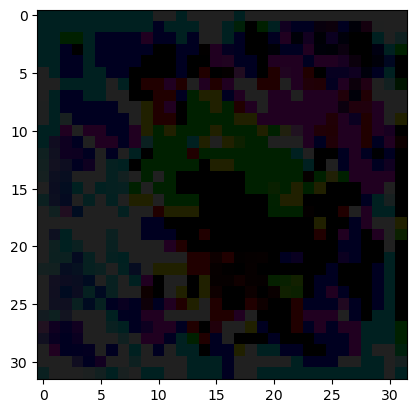

Noise max val: tensor(0.1255, device='cuda:5', grad_fn=<MaxBackward1>)


In [13]:
#Trigger generating stage
for param in poi_warm_up_model.parameters():
    param.requires_grad = False

batch_pert = torch.autograd.Variable(noise.cuda(), requires_grad=True)
batch_opt = torch.optim.RAdam(params=[batch_pert],lr=generating_lr_tri)
for minmin in tqdm.notebook.tqdm(range(gen_round)):
    loss_list = []
    for images, labels in trigger_gen_loaders:
        images, labels = images.cuda(), labels.cuda()
        new_images = torch.clone(images)
        clamp_batch_pert = torch.clamp(batch_pert,-l_inf_r*2,l_inf_r*2)
        new_images = torch.clamp(apply_noise_patch(clamp_batch_pert,new_images.clone(),mode=patch_mode),-1,1)
        per_logits = poi_warm_up_model.forward(new_images)
        loss = criterion(per_logits, labels)

        loss_regu = torch.mean(loss)
        batch_opt.zero_grad()
        loss_list.append(float(loss_regu.data))
        loss_regu.backward(retain_graph = True)
        batch_opt.step()
    ave_loss = np.average(np.array(loss_list))
    ave_grad = np.sum(abs(batch_pert.grad).detach().cpu().numpy())
    print('Gradient:',ave_grad,'Loss:', ave_loss)
    if ave_grad == 0:
        break

noise = torch.clamp(batch_pert,-l_inf_r*2,l_inf_r*2)
best_noise = noise.clone().detach().cpu()
plt.imshow(np.transpose(noise[0].detach().cpu(),(1,2,0)))
plt.show()
print('Noise max val:',noise.max())


In [ ]:
#Save the trigger
import time
save_name = './checkpoint/best_noise'+'_'+ time.strftime("%m-%d-%H_%M_%S",time.localtime(time.time())) 
np.save(save_name, best_noise)


In [73]:
#Poisoning amount use for the target class
poison_amount = 1000

#Model uses for testing
noise_testing_model = ResNet18().cuda()    

#Training parameters
training_epochs = 200
training_lr = 0.1
test_batch_size = 150

#The multiple of noise amplification during testing
multi_test = 3

#random seed for testing stage
random_seed = 65


In [74]:

import torchvision.models as models
np.random.seed(random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)
# model = noise_testing_model
model=ResNet18().cuda()
optimizer = torch.optim.SGD(params=model.parameters(), lr=training_lr, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=training_epochs)


     

transform_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
poi_ori_train = torchvision.datasets.CIFAR10(root=root, train=True, download=True, transform=transform_tensor)
poi_ori_test = torchvision.datasets.CIFAR10(root=root, train=False, download=True, transform=transform_tensor)
transform_after_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  
    transforms.RandomHorizontalFlip(),
])


Files already downloaded and verified
Files already downloaded and verified


In [75]:
#Poison traing
random_poison_idx = random.sample(train_target_list, poison_amount)
poison_train_target = poison_image(poi_ori_train,random_poison_idx,best_noise.cpu(),transform_after_train)
print('Traing dataset size is:',len(poison_train_target)," Poison numbers is:",len(random_poison_idx))
clean_train_loader = DataLoader(poison_train_target, batch_size=test_batch_size, shuffle=True, num_workers=2)


Traing dataset size is: 50000  Poison numbers is: 1000


In [76]:
random_poison_idx

[33677,
 23343,
 23222,
 41763,
 17561,
 35887,
 36921,
 42993,
 35862,
 44909,
 27549,
 35405,
 17980,
 5715,
 45785,
 37647,
 21284,
 15696,
 38129,
 3476,
 20671,
 9053,
 12782,
 42986,
 10968,
 9917,
 11099,
 28593,
 30021,
 47123,
 29943,
 18376,
 18162,
 32330,
 36316,
 38451,
 3845,
 12361,
 1745,
 27186,
 20061,
 25984,
 21836,
 737,
 13777,
 34930,
 5836,
 21018,
 44584,
 803,
 14569,
 13059,
 46766,
 43747,
 35146,
 10616,
 41894,
 34062,
 26215,
 17834,
 19070,
 24195,
 45303,
 28948,
 15563,
 30251,
 47127,
 49053,
 533,
 24789,
 5166,
 21591,
 23346,
 36510,
 13042,
 10624,
 10725,
 7303,
 22397,
 35031,
 48391,
 32181,
 30454,
 44491,
 6414,
 46478,
 33121,
 12200,
 13130,
 39854,
 39324,
 23692,
 38535,
 26855,
 40960,
 25174,
 12058,
 48522,
 38365,
 45795,
 1670,
 7308,
 14399,
 42158,
 28107,
 43745,
 2537,
 14013,
 21392,
 17016,
 21412,
 23677,
 19236,
 25366,
 32059,
 12506,
 33890,
 11187,
 40704,
 22618,
 7380,
 45990,
 49683,
 43365,
 38244,
 21860,
 17690,
 174

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


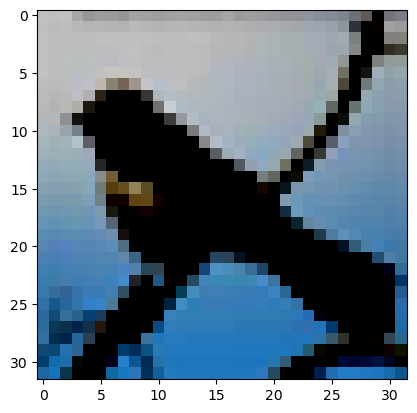

In [77]:
plt.imshow(np.transpose(poi_ori_train[808][0],(1,2,0)))

### Plot the image to see if trigger is visible 



In [78]:
#separate model if you chose to use
# class SmallCNN(nn.Module):
#     def __init__(self):
#         super(SmallCNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x, last=False):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 16 * 5 * 5)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         output = self.fc3(x)
        
#         if last:
#             return output, x
#         else:
#             return output

# #     def getFeature(self, x, numpy=True):
# #         if x.shape[1]==32:
# #           x = np.moveaxis(x, 3, 1)
# #         x = torch.Tensor(x).cuda()
# #         x = self.pool(F.relu(self.conv1(x)))
# #         x = self.pool(F.relu(self.conv2(x)))
# #         x = torch.flatten(x, 1)
# #         if numpy:
# #           return x.detach().cpu().numpy()
# #         else:
# #           return x

# #     def get_embedding_dim(self):
# #         return 84


## Eval Stage


In [79]:

from torchvision.models import resnet18
# model=noise_testing_model
criterion=nn.CrossEntropyLoss()

# Convert batchnorm modules to Group Norm modules for DP-SGD
from opacus.utils.module_modification import convert_batchnorm_modules


model = convert_batchnorm_modules(model) #comment out if not implementing DP-SGD 
model=model.to(device)
# Note that we are using the backbone as a black-box featurizer. It's never trained, so we can keep BatchNorms in there.
# model=SmallCNN().cuda()

# The optimizer needs to point to the new model

optimizer=torch.optim.SGD(model.parameters(), lr=0.1 ,
                      momentum=0.9, weight_decay=5e-4, nesterov=True)

In [80]:
#Comment out cell if not implementing DP-SGD
privacy_engine=opacus.PrivacyEngine(model,
                                   batch_size=64,
                                   sample_size=50000,
                                   alphas=range(2,32),
                                   noise_multiplier=0.01,
                                   
                                   max_grad_norm=8.0)
privacy_engine.attach(optimizer)

/home/himanshugj/miniconda3/envs/project1/lib/python3.7/site-packages/opacus/privacy_engine.py:753: UserWarning: The sample rate will be defined from ``batch_size`` and ``sample_size``.The returned privacy budget will be incorrect.
  "The sample rate will be defined from ``batch_size`` and ``sample_size``."
/home/himanshugj/miniconda3/envs/project1/lib/python3.7/site-packages/opacus/privacy_engine.py:237: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "


In [81]:

#Attack success rate testing
test_non_target = list(np.where(np.array(test_label)!=lab)[0])
test_non_target_change_image_label = poison_image_label(poi_ori_test,test_non_target,best_noise.cpu()*multi_test,lab,None)
asr_loaders = torch.utils.data.DataLoader(test_non_target_change_image_label, batch_size=test_batch_size, shuffle=True, num_workers=2)
print('Poison test dataset size is:',len(test_non_target_change_image_label))

Poison test dataset size is: 9000


In [82]:
#Clean acc test dataset
clean_test_loader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=False, num_workers=2)

In [83]:
#Target clean test dataset
test_target = list(np.where(np.array(test_label)==lab)[0])
target_test_set = Subset(testset,test_target)
target_test_loader = torch.utils.data.DataLoader(target_test_set, batch_size=test_batch_size, shuffle=True, num_workers=2)



In [84]:

# from util import AverageMeter
train_ACC = []
test_ACC = []
clean_ACC = []
target_ACC = []


In [85]:
delta=1e-5
for epoch in tqdm.notebook.tqdm(range(training_epochs)):
    # Train
    model.train()
    acc_meter = AverageMeter()
    loss_meter = AverageMeter()
    pbar = tqdm.notebook.tqdm(clean_train_loader, total=len(clean_train_loader))
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        model.zero_grad()
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()

        optimizer.step()
        
        _, predicted = torch.max(logits.data, 1)
        acc = (predicted == labels).sum().item()/labels.size(0)
        acc_meter.update(acc)
        loss_meter.update(loss.item())
        pbar.set_description("Acc %.2f Loss: %.2f" % (acc_meter.avg*100, loss_meter.avg))
    epsilon, best_alpha = optimizer.privacy_engine.get_privacy_spent(delta)

    train_ACC.append(acc_meter.avg)
    print('Train_loss:',loss)
#     scheduler.step()
    
    # Testing attack effect
    model.eval()
    correct, total = 0, 0
    for i, (images, labels) in enumerate(asr_loaders):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            logits = model(images)
            out_loss = criterion(logits,labels)
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    test_ACC.append(acc)
    print('\nAttack success rate %.2f' % (acc*100))
    print('Test_loss:',out_loss)
    
    correct_clean, total_clean = 0, 0
    for i, (images, labels) in enumerate(clean_test_loader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            logits = model(images)
            out_loss = criterion(logits,labels)
            _, predicted = torch.max(logits.data, 1)
            total_clean += labels.size(0)
            correct_clean += (predicted == labels).sum().item()
    acc_clean = correct_clean / total_clean
    clean_ACC.append(acc_clean)
    print('\nTest clean Accuracy %.2f' % (acc_clean*100))
    print('Test_loss:',out_loss)
    
    correct_tar, total_tar = 0, 0
    for i, (images, labels) in enumerate(target_test_loader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            logits = model(images)
            out_loss = criterion(logits,labels)
            _, predicted = torch.max(logits.data, 1)
            total_tar += labels.size(0)
            correct_tar += (predicted == labels).sum().item()
    acc_tar = correct_tar / total_tar
    target_ACC.append(acc_tar)
    print('\nTarget test clean Accuracy %.2f' % (acc_tar*100))
    print('Test_loss:',out_loss)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/334 [00:00<?, ?it/s]

/home/himanshugj/miniconda3/envs/project1/lib/python3.7/site-packages/torch/nn/modules/module.py:1113: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "



Attack success rate 5.52
Test_loss: tensor(3.1275, device='cuda:5')

Test clean Accuracy 44.26
Test_loss: tensor(1.8434, device='cuda:5')

Target test clean Accuracy 26.00
Test_loss: tensor(3.0416, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(1.3976, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 72.26
Test_loss: tensor(0.8954, device='cuda:5')

Test clean Accuracy 44.36
Test_loss: tensor(1.9970, device='cuda:5')

Target test clean Accuracy 23.00
Test_loss: tensor(2.5275, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.8031, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 75.78
Test_loss: tensor(0.8585, device='cuda:5')

Test clean Accuracy 61.83
Test_loss: tensor(1.1586, device='cuda:5')

Target test clean Accuracy 50.80
Test_loss: tensor(1.4697, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train_loss: tensor(0.7526, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 95.88
Test_loss: tensor(0.2082, device='cuda:5')

Test clean Accuracy 74.88
Test_loss: tensor(0.9358, device='cuda:5')

Target test clean Accuracy 67.30
Test_loss: tensor(1.3167, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(1.2315, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 85.78
Test_loss: tensor(0.6433, device='cuda:5')

Test clean Accuracy 58.97
Test_loss: tensor(1.8816, device='cuda:5')

Target test clean Accuracy 30.70
Test_loss: tensor(3.0592, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5395, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 96.13
Test_loss: tensor(0.2793, device='cuda:5')

Test clean Accuracy 71.35
Test_loss: tensor(1.1088, device='cuda:5')

Target test clean Accuracy 67.40
Test_loss: tensor(1.3000, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.6965, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 96.61
Test_loss: tensor(0.2073, device='cuda:5')

Test clean Accuracy 70.52
Test_loss: tensor(1.1519, device='cuda:5')

Target test clean Accuracy 49.70
Test_loss: tensor(1.6776, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.6583, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 86.00
Test_loss: tensor(0.5523, device='cuda:5')

Test clean Accuracy 68.29
Test_loss: tensor(1.1499, device='cuda:5')

Target test clean Accuracy 41.10
Test_loss: tensor(1.8792, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train_loss: tensor(0.9138, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.49
Test_loss: tensor(0.0180, device='cuda:5')

Test clean Accuracy 77.31
Test_loss: tensor(0.7784, device='cuda:5')

Target test clean Accuracy 50.80
Test_loss: tensor(2.2284, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5433, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 58.20
Test_loss: tensor(1.8218, device='cuda:5')

Test clean Accuracy 63.08
Test_loss: tensor(1.9367, device='cuda:5')

Target test clean Accuracy 34.50
Test_loss: tensor(3.0344, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(1.0531, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.81
Test_loss: tensor(0.0585, device='cuda:5')

Test clean Accuracy 63.09
Test_loss: tensor(1.5771, device='cuda:5')

Target test clean Accuracy 66.20
Test_loss: tensor(1.7509, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.7757, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.93
Test_loss: tensor(0.0019, device='cuda:5')

Test clean Accuracy 73.20
Test_loss: tensor(1.2864, device='cuda:5')

Target test clean Accuracy 57.30
Test_loss: tensor(1.7130, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.6188, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 94.99
Test_loss: tensor(0.1695, device='cuda:5')

Test clean Accuracy 68.62
Test_loss: tensor(1.5320, device='cuda:5')

Target test clean Accuracy 32.70
Test_loss: tensor(3.3861, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train_loss: tensor(0.5071, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.57
Test_loss: tensor(0.0644, device='cuda:5')

Test clean Accuracy 72.06
Test_loss: tensor(1.0934, device='cuda:5')

Target test clean Accuracy 45.10
Test_loss: tensor(2.5505, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(1.3528, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.96
Test_loss: tensor(0.0017, device='cuda:5')

Test clean Accuracy 65.98
Test_loss: tensor(1.5793, device='cuda:5')

Target test clean Accuracy 54.90
Test_loss: tensor(2.2389, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3701, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.92
Test_loss: tensor(0.0022, device='cuda:5')

Test clean Accuracy 69.27
Test_loss: tensor(1.3804, device='cuda:5')

Target test clean Accuracy 63.20
Test_loss: tensor(1.2987, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.9690, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.93
Test_loss: tensor(0.0015, device='cuda:5')

Test clean Accuracy 67.50
Test_loss: tensor(1.3551, device='cuda:5')

Target test clean Accuracy 47.50
Test_loss: tensor(2.9741, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(1.0251, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.84
Test_loss: tensor(0.0018, device='cuda:5')

Test clean Accuracy 70.74
Test_loss: tensor(1.3556, device='cuda:5')

Target test clean Accuracy 65.40
Test_loss: tensor(1.3784, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.9733, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.97
Test_loss: tensor(0.0009, device='cuda:5')

Test clean Accuracy 74.74
Test_loss: tensor(1.0104, device='cuda:5')

Target test clean Accuracy 64.60
Test_loss: tensor(1.5672, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5055, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.96
Test_loss: tensor(0.0019, device='cuda:5')

Test clean Accuracy 74.23
Test_loss: tensor(1.0673, device='cuda:5')

Target test clean Accuracy 43.60
Test_loss: tensor(2.9993, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(1.1812, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 100.00
Test_loss: tensor(0.0009, device='cuda:5')

Test clean Accuracy 74.51
Test_loss: tensor(0.8426, device='cuda:5')

Target test clean Accuracy 80.20
Test_loss: tensor(0.8530, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train_loss: tensor(0.6640, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.98
Test_loss: tensor(0.0016, device='cuda:5')

Test clean Accuracy 63.01
Test_loss: tensor(1.4954, device='cuda:5')

Target test clean Accuracy 39.40
Test_loss: tensor(2.8309, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(1.1293, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.89
Test_loss: tensor(0.0013, device='cuda:5')

Test clean Accuracy 68.64
Test_loss: tensor(1.4575, device='cuda:5')

Target test clean Accuracy 31.40
Test_loss: tensor(2.6047, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Attack success rate 90.70
Test_loss: tensor(0.1978, device='cuda:5')

Test clean Accuracy 73.39
Test_loss: tensor(1.0932, device='cuda:5')

Target test clean Accuracy 40.00
Test_loss: tensor(2.7500, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.9562, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 100.00
Test_loss: tensor(0.0013, device='cuda:5')

Test clean Accuracy 69.40
Test_loss: tensor(1.4433, device='cuda:5')

Target test clean Accuracy 46.10
Test_loss: tensor(2.8268, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.9842, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 100.00
Test_loss: tensor(0.0009, device='cuda:5')

Test clean Accuracy 61.15
Test_loss: tensor(1.7741, device='cuda:5')

Target test clean Accuracy 68.60
Test_loss: tensor(1.5414, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train_loss: tensor(0.8631, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.98
Test_loss: tensor(0.0008, device='cuda:5')

Test clean Accuracy 72.92
Test_loss: tensor(1.4038, device='cuda:5')

Target test clean Accuracy 53.00
Test_loss: tensor(1.5251, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.7859, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.91
Test_loss: tensor(0.0013, device='cuda:5')

Test clean Accuracy 72.92
Test_loss: tensor(1.2135, device='cuda:5')

Target test clean Accuracy 73.40
Test_loss: tensor(1.1817, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train_loss: tensor(0.9201, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 100.00
Test_loss: tensor(0.0016, device='cuda:5')

Test clean Accuracy 73.29
Test_loss: tensor(1.3139, device='cuda:5')

Target test clean Accuracy 53.60
Test_loss: tensor(2.2363, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5394, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.98
Test_loss: tensor(0.0011, device='cuda:5')

Test clean Accuracy 61.56
Test_loss: tensor(1.8080, device='cuda:5')

Target test clean Accuracy 25.10
Test_loss: tensor(4.0335, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.8888, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 100.00
Test_loss: tensor(0.0010, device='cuda:5')

Test clean Accuracy 72.93
Test_loss: tensor(0.8559, device='cuda:5')

Target test clean Accuracy 72.70
Test_loss: tensor(0.9968, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Test clean Accuracy 79.31
Test_loss: tensor(0.7613, device='cuda:5')

Target test clean Accuracy 72.70
Test_loss: tensor(1.0132, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5514, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 100.00
Test_loss: tensor(0.0011, device='cuda:5')

Test clean Accuracy 77.21
Test_loss: tensor(0.9752, device='cuda:5')

Target test clean Accuracy 58.10
Test_loss: tensor(2.2402, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.9936, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 100.00
Test_loss: tensor(0.0011, device='cuda:5')

Test clean Accuracy 79.90
Test_loss: tensor(0.8455, device='cuda:5')

Target test clean Accuracy 82.80
Test_loss: tensor(0.7153, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1846, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.91
Test_loss: tensor(0.0020, device='cuda:5')

Test clean Accuracy 77.28
Test_loss: tensor(0.8250, device='cuda:5')

Target test clean Accuracy 51.10
Test_loss: tensor(2.4598, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5780, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.78
Test_loss: tensor(0.0012, device='cuda:5')

Test clean Accuracy 76.44
Test_loss: tensor(1.1688, device='cuda:5')

Target test clean Accuracy 55.10
Test_loss: tensor(1.8303, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4920, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 100.00
Test_loss: tensor(0.0014, device='cuda:5')

Test clean Accuracy 78.24
Test_loss: tensor(0.9981, device='cuda:5')

Target test clean Accuracy 69.10
Test_loss: tensor(1.4884, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.8228, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 100.00
Test_loss: tensor(0.0007, device='cuda:5')

Test clean Accuracy 77.92
Test_loss: tensor(0.6433, device='cuda:5')

Target test clean Accuracy 72.70
Test_loss: tensor(1.0171, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.6599, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.99
Test_loss: tensor(0.0010, device='cuda:5')

Test clean Accuracy 76.93
Test_loss: tensor(1.0789, device='cuda:5')

Target test clean Accuracy 65.40
Test_loss: tensor(1.8332, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.8378, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.99
Test_loss: tensor(0.0009, device='cuda:5')

Test clean Accuracy 71.30
Test_loss: tensor(1.1595, device='cuda:5')

Target test clean Accuracy 59.60
Test_loss: tensor(2.3053, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4139, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 100.00
Test_loss: tensor(0.0008, device='cuda:5')

Test clean Accuracy 80.27
Test_loss: tensor(0.8193, device='cuda:5')

Target test clean Accuracy 56.10
Test_loss: tensor(1.9845, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4880, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 85.44
Test_loss: tensor(0.5398, device='cuda:5')

Test clean Accuracy 74.94
Test_loss: tensor(1.2190, device='cuda:5')

Target test clean Accuracy 31.40
Test_loss: tensor(3.2903, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.9644, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.98
Test_loss: tensor(0.0017, device='cuda:5')

Test clean Accuracy 77.71
Test_loss: tensor(0.9492, device='cuda:5')

Target test clean Accuracy 73.20
Test_loss: tensor(0.9855, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(1.1951, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 100.00
Test_loss: tensor(0.0013, device='cuda:5')

Test clean Accuracy 73.71
Test_loss: tensor(1.1363, device='cuda:5')

Target test clean Accuracy 74.90
Test_loss: tensor(1.4305, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2954, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.89
Test_loss: tensor(0.0010, device='cuda:5')

Test clean Accuracy 76.20
Test_loss: tensor(0.7518, device='cuda:5')

Target test clean Accuracy 36.30
Test_loss: tensor(2.8053, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(1.1559, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.99
Test_loss: tensor(0.0013, device='cuda:5')

Test clean Accuracy 58.03
Test_loss: tensor(1.9866, device='cuda:5')

Target test clean Accuracy 48.50
Test_loss: tensor(2.3213, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.6028, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 100.00
Test_loss: tensor(0.0014, device='cuda:5')

Test clean Accuracy 77.13
Test_loss: tensor(1.2233, device='cuda:5')

Target test clean Accuracy 59.50
Test_loss: tensor(1.7330, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(1.1745, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 100.00
Test_loss: tensor(0.0010, device='cuda:5')

Test clean Accuracy 77.94
Test_loss: tensor(0.6772, device='cuda:5')

Target test clean Accuracy 65.50
Test_loss: tensor(1.3504, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.7063, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 100.00
Test_loss: tensor(0.0009, device='cuda:5')

Test clean Accuracy 76.77
Test_loss: tensor(0.7941, device='cuda:5')

Target test clean Accuracy 69.90
Test_loss: tensor(1.4632, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.6587, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 100.00
Test_loss: tensor(0.0008, device='cuda:5')

Test clean Accuracy 78.89
Test_loss: tensor(0.5901, device='cuda:5')

Target test clean Accuracy 53.70
Test_loss: tensor(2.0696, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.8458, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.53
Test_loss: tensor(0.0035, device='cuda:5')

Test clean Accuracy 67.56
Test_loss: tensor(1.4923, device='cuda:5')

Target test clean Accuracy 35.10
Test_loss: tensor(3.5356, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4257, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.98
Test_loss: tensor(0.0011, device='cuda:5')

Test clean Accuracy 77.70
Test_loss: tensor(1.0602, device='cuda:5')

Target test clean Accuracy 65.20
Test_loss: tensor(1.6074, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(1.0781, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 100.00
Test_loss: tensor(0.0014, device='cuda:5')

Test clean Accuracy 75.09
Test_loss: tensor(0.7546, device='cuda:5')

Target test clean Accuracy 51.60
Test_loss: tensor(2.5590, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.8795, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 100.00
Test_loss: tensor(0.0007, device='cuda:5')

Test clean Accuracy 75.17
Test_loss: tensor(1.0317, device='cuda:5')

Target test clean Accuracy 52.00
Test_loss: tensor(1.8973, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.6360, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 95.94
Test_loss: tensor(0.1933, device='cuda:5')

Test clean Accuracy 73.86
Test_loss: tensor(1.5000, device='cuda:5')

Target test clean Accuracy 65.30
Test_loss: tensor(2.0665, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.6927, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 100.00
Test_loss: tensor(0.0011, device='cuda:5')

Test clean Accuracy 72.91
Test_loss: tensor(1.3065, device='cuda:5')

Target test clean Accuracy 93.20
Test_loss: tensor(0.0999, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.6916, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.97
Test_loss: tensor(0.0012, device='cuda:5')

Test clean Accuracy 77.25
Test_loss: tensor(0.9858, device='cuda:5')

Target test clean Accuracy 65.90
Test_loss: tensor(1.3069, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5902, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 100.00
Test_loss: tensor(0.0007, device='cuda:5')

Test clean Accuracy 72.29
Test_loss: tensor(0.9899, device='cuda:5')

Target test clean Accuracy 85.40
Test_loss: tensor(0.4474, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.9844, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 100.00
Test_loss: tensor(0.0014, device='cuda:5')

Test clean Accuracy 78.63
Test_loss: tensor(1.2357, device='cuda:5')

Target test clean Accuracy 72.50
Test_loss: tensor(1.1559, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5724, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.99
Test_loss: tensor(0.0028, device='cuda:5')

Test clean Accuracy 71.48
Test_loss: tensor(1.1798, device='cuda:5')

Target test clean Accuracy 47.90
Test_loss: tensor(2.7011, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5142, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.89
Test_loss: tensor(0.0015, device='cuda:5')

Test clean Accuracy 72.42
Test_loss: tensor(1.1787, device='cuda:5')

Target test clean Accuracy 50.30
Test_loss: tensor(2.4785, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(1.0589, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.86
Test_loss: tensor(0.0024, device='cuda:5')

Test clean Accuracy 52.30
Test_loss: tensor(2.3604, device='cuda:5')

Target test clean Accuracy 29.20
Test_loss: tensor(4.0024, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2535, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 100.00
Test_loss: tensor(0.0008, device='cuda:5')

Test clean Accuracy 82.64
Test_loss: tensor(0.5616, device='cuda:5')

Target test clean Accuracy 80.50
Test_loss: tensor(0.8718, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.8044, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.69
Test_loss: tensor(0.0275, device='cuda:5')

Test clean Accuracy 78.81
Test_loss: tensor(1.1122, device='cuda:5')

Target test clean Accuracy 54.70
Test_loss: tensor(1.7549, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.7514, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 100.00
Test_loss: tensor(0.0013, device='cuda:5')

Test clean Accuracy 71.75
Test_loss: tensor(1.1023, device='cuda:5')

Target test clean Accuracy 55.40
Test_loss: tensor(2.0656, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.9625, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 100.00
Test_loss: tensor(0.0007, device='cuda:5')

Test clean Accuracy 71.77
Test_loss: tensor(1.0077, device='cuda:5')

Target test clean Accuracy 78.10
Test_loss: tensor(0.6268, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.7555, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.72
Test_loss: tensor(0.0025, device='cuda:5')

Test clean Accuracy 74.02
Test_loss: tensor(1.1873, device='cuda:5')

Target test clean Accuracy 44.10
Test_loss: tensor(2.5933, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.7338, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 100.00
Test_loss: tensor(0.0011, device='cuda:5')

Test clean Accuracy 76.64
Test_loss: tensor(1.0565, device='cuda:5')

Target test clean Accuracy 76.90
Test_loss: tensor(1.1164, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5067, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.97
Test_loss: tensor(0.0011, device='cuda:5')

Test clean Accuracy 68.67
Test_loss: tensor(1.5266, device='cuda:5')

Target test clean Accuracy 29.60
Test_loss: tensor(3.8582, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.7793, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.97
Test_loss: tensor(0.0012, device='cuda:5')

Test clean Accuracy 77.01
Test_loss: tensor(1.2366, device='cuda:5')

Target test clean Accuracy 50.50
Test_loss: tensor(2.3387, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4517, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.99
Test_loss: tensor(0.0018, device='cuda:5')

Test clean Accuracy 67.85
Test_loss: tensor(1.3464, device='cuda:5')

Target test clean Accuracy 58.10
Test_loss: tensor(2.1505, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5835, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 100.00
Test_loss: tensor(0.0010, device='cuda:5')

Test clean Accuracy 81.42
Test_loss: tensor(0.4159, device='cuda:5')

Target test clean Accuracy 69.30
Test_loss: tensor(1.6953, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.6572, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.97
Test_loss: tensor(0.0019, device='cuda:5')

Test clean Accuracy 74.05
Test_loss: tensor(1.1475, device='cuda:5')

Target test clean Accuracy 37.80
Test_loss: tensor(2.7401, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.9015, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 100.00
Test_loss: tensor(0.0009, device='cuda:5')

Test clean Accuracy 73.41
Test_loss: tensor(1.1685, device='cuda:5')

Target test clean Accuracy 78.60
Test_loss: tensor(1.0087, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5301, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 100.00
Test_loss: tensor(0.0008, device='cuda:5')

Test clean Accuracy 73.63
Test_loss: tensor(0.6038, device='cuda:5')

Target test clean Accuracy 76.70
Test_loss: tensor(0.7446, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5632, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 100.00
Test_loss: tensor(0.0013, device='cuda:5')

Test clean Accuracy 76.84
Test_loss: tensor(0.9618, device='cuda:5')

Target test clean Accuracy 65.30
Test_loss: tensor(1.2706, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.7497, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.99
Test_loss: tensor(0.0011, device='cuda:5')

Test clean Accuracy 77.75
Test_loss: tensor(0.8109, device='cuda:5')

Target test clean Accuracy 68.40
Test_loss: tensor(1.4308, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3119, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.98
Test_loss: tensor(0.0012, device='cuda:5')

Test clean Accuracy 73.65
Test_loss: tensor(1.3366, device='cuda:5')

Target test clean Accuracy 34.60
Test_loss: tensor(3.5721, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5026, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 100.00
Test_loss: tensor(0.0008, device='cuda:5')

Test clean Accuracy 71.55
Test_loss: tensor(1.1551, device='cuda:5')

Target test clean Accuracy 61.50
Test_loss: tensor(1.7817, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.9563, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.98
Test_loss: tensor(0.0016, device='cuda:5')

Test clean Accuracy 75.41
Test_loss: tensor(0.9126, device='cuda:5')

Target test clean Accuracy 52.80
Test_loss: tensor(2.1950, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4160, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 100.00
Test_loss: tensor(0.0013, device='cuda:5')

Test clean Accuracy 75.88
Test_loss: tensor(1.1870, device='cuda:5')

Target test clean Accuracy 52.20
Test_loss: tensor(2.4249, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.7798, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.84
Test_loss: tensor(0.0011, device='cuda:5')

Test clean Accuracy 76.88
Test_loss: tensor(0.8458, device='cuda:5')

Target test clean Accuracy 43.00
Test_loss: tensor(2.8095, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(1.3909, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 100.00
Test_loss: tensor(0.0012, device='cuda:5')

Test clean Accuracy 70.81
Test_loss: tensor(1.3837, device='cuda:5')

Target test clean Accuracy 54.50
Test_loss: tensor(2.2008, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.6333, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.89
Test_loss: tensor(0.0009, device='cuda:5')

Test clean Accuracy 78.15
Test_loss: tensor(0.9411, device='cuda:5')

Target test clean Accuracy 66.50
Test_loss: tensor(1.1836, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5091, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 100.00
Test_loss: tensor(0.0007, device='cuda:5')

Test clean Accuracy 78.30
Test_loss: tensor(1.1602, device='cuda:5')

Target test clean Accuracy 76.00
Test_loss: tensor(0.9162, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4888, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.99
Test_loss: tensor(0.0009, device='cuda:5')

Test clean Accuracy 77.63
Test_loss: tensor(0.9735, device='cuda:5')

Target test clean Accuracy 52.80
Test_loss: tensor(2.2144, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.7089, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 100.00
Test_loss: tensor(0.0020, device='cuda:5')

Test clean Accuracy 70.48
Test_loss: tensor(1.2866, device='cuda:5')

Target test clean Accuracy 47.00
Test_loss: tensor(2.0591, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.6630, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 100.00
Test_loss: tensor(0.0011, device='cuda:5')

Test clean Accuracy 76.53
Test_loss: tensor(1.2368, device='cuda:5')

Target test clean Accuracy 65.80
Test_loss: tensor(1.6346, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.9616, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.99
Test_loss: tensor(0.0012, device='cuda:5')

Test clean Accuracy 80.69
Test_loss: tensor(0.6137, device='cuda:5')

Target test clean Accuracy 70.30
Test_loss: tensor(1.2125, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4401, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 100.00
Test_loss: tensor(0.0008, device='cuda:5')

Test clean Accuracy 79.49
Test_loss: tensor(0.5670, device='cuda:5')

Target test clean Accuracy 81.00
Test_loss: tensor(0.4827, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(1.1663, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 99.96
Test_loss: tensor(0.0012, device='cuda:5')

Test clean Accuracy 79.74
Test_loss: tensor(0.8748, device='cuda:5')

Target test clean Accuracy 59.70
Test_loss: tensor(1.5575, device='cuda:5')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5693, device='cuda:5', grad_fn=<NllLossBackward0>)

Attack success rate 100.00
Test_loss: tensor(0.0013, device='cuda:5')

Test clean Accuracy 68.50
Test_loss: tensor(1.6092, device='cuda:5')

Target test clean Accuracy 46.90
Test_loss: tensor(2.4541, device='cuda:5')


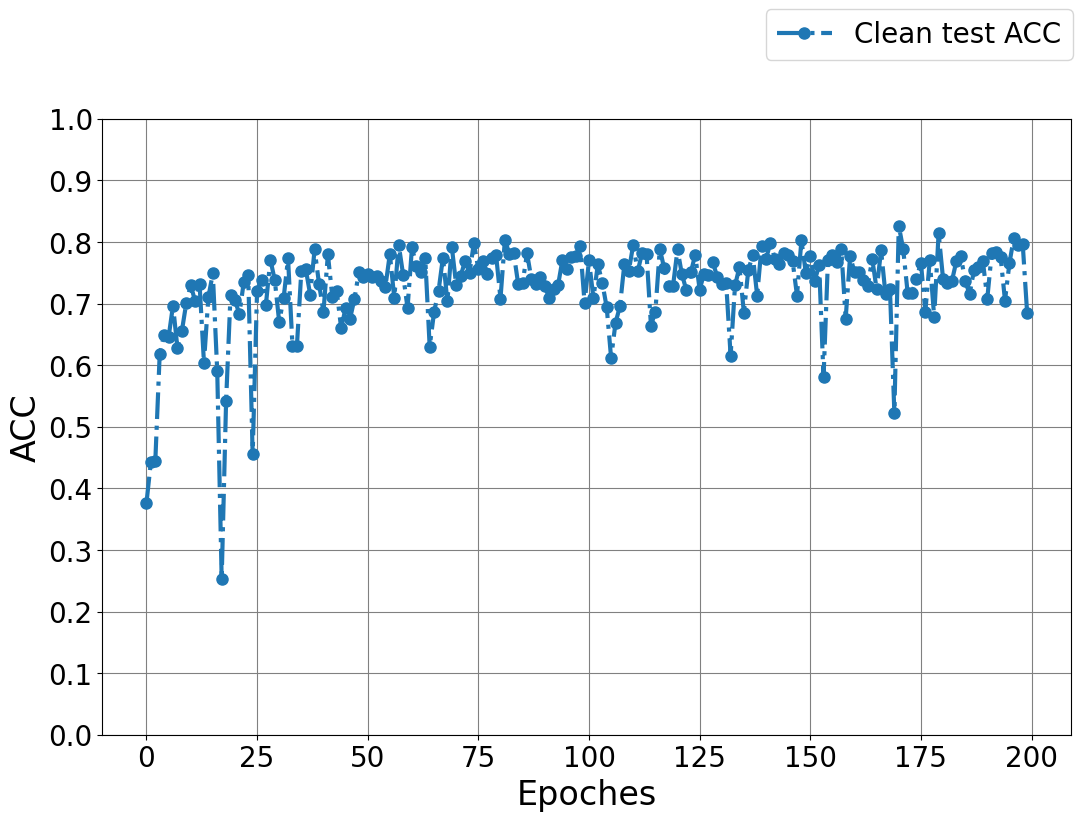

0.8376047904191617
attack 1.0
170
all class clean 0.8264
target clean 0.805


In [90]:
#ours -- higher_configureations
from matplotlib import pyplot as plt
half = np.arange(0,training_epochs)
plt.figure(figsize=(12.5,8))
# plt.plot(half, np.asarray(train_ACC)[half], label='Training ACC', linestyle="-.", marker="o", linewidth=3.0, markersize = 8)
# plt.plot(half, np.asarray(test_ACC)[half], label='Attack success rate', linestyle="-.", marker="o", linewidth=3.0, markersize = 8)
plt.plot(half, np.asarray(clean_ACC)[half], label='Clean test ACC', linestyle="-.", marker="o", linewidth=3.0, markersize = 8)
# plt.plot(half, np.asarray(target_ACC)[half], label='Target class clean test ACC', linestyle="-", marker="o", linewidth=3.0, markersize = 8)
# plt.plot(half, np.asarray(test_unl_ACC)[half], label='protected test ACC', linestyle="-.", marker="o", linewidth=3.0, markersize = 8)
plt.ylabel('ACC', fontsize=24)
plt.xticks(fontsize=20)
plt.xlabel('Epoches', fontsize=24)
plt.yticks(np.arange(0,1.1, 0.1),fontsize=20)
plt.legend(fontsize=20,bbox_to_anchor=(1.016, 1.2),ncol=2)
plt.grid(color="gray", linestyle="-")
plt.show()

dis_idx = clean_ACC.index(max(clean_ACC))
print(train_ACC[dis_idx])
print('attack',test_ACC[dis_idx])
print(clean_ACC.index(max(clean_ACC)))
print('all class clean', clean_ACC[dis_idx])
print('target clean',target_ACC[dis_idx])

### Attack successful